# Multimodal Image Alignment with Remote Sensing Data

## Introduction

This is my solution to the image registration challenge given to me as an interview coding assignment. I will first give a brief problem description, followed by an overview of my solution. In the next section I provide a step-by-step walk-through of the code solving this problem. I conclude with a look at the limitations of the approach and possible further improvements.

Apologies in advance for any incorrectly used terminology. This problem and application area are fairly new to me.

## Problem and Task

Aerobotics uses drones to capture images of farms from above. Numerous images are taken of an area and are then stitched together to form an orthomosaic of the whole area. Image data is collected using multiple different cameras. Sometimes the orthomosaics from the different cameras do not align geographically and thus they need a way to align them.

The task in this assignment is to align grayscale images taken with a multispectral camera (NDVI) with 3-band visual (RGB) images taken from a normal camera.

## Overview of Approach Taken

The core of this approach is a classic computer vision feature matching technique. In order for it to work over the different modalities we first try to make the RGB image look like the NDVI image. We do this by transforming the RGB image into a TGI image. Then a set of (SIFT) features are detected in the NDVI image which is matched with the features in the TGI image. A transformation can then be calculated, using the RANSAC algorithm) based on these matched features that warps the NDVI image on to the TGI image. We assign the GeoTransform and GeoProjection parameters of the RGB geotif to the new aligned NDVI raster which gives us an aligned gray NDVI geotif file.

## Method and Code

For this notebook to run, you need to download the data at: https://drive.google.com/drive/folders/1POfchsfyqLI2G6D6enAW18VB8ZEQkgHw (the one shared with me over email) and place it in the `datasets/` directory. Also change the name of `6574-misaligned` to `6574` and similarly, `6568-misaligned` to `6568`

We only need the following 4 libraries for this notebook (I provide the versions I used next to each of the import lines):

In [1]:
from osgeo import gdal # 2.2.3
from matplotlib import pyplot as plt # 2.1.1
import numpy as np # 1.14.0
import cv2 # 3.4.0

I've also only tested the code using Python 3.6.5

To load the geotif files, I use this helper function which returns the raster image and the transform parameters of the geotif file given the file path.

In [2]:
def open_geotif(pth):
    
    gdal_ob = gdal.Open(pth, gdal.GA_ReadOnly) # load gdal object
    im = gdal_ob.ReadAsArray() # get raster
    
    # transpose to valid image dimensions if necessary
    if len(im.shape) == 3: im = im.transpose([1,2,0])[:,:,:3]
        
    # get transform paramters and store the relevant items in a dictionary
    trans = gdal_ob.GetGeoTransform()
    trans_dict = dict({'lat_origin': trans[3], 'lon_origin': trans[0], 
                       'delta_lat': trans[5], 'delta_lon': trans[1]}) 
    return im, trans_dict

Set the index of the dataset we wish to align. Options are: 6543, 6558, 6560, 6568, 6574 and 8336

In [3]:
ds = 6568

Load the RGB and misaligned NDVI files.

In [4]:
rgb_raster, rgb_trans = open_geotif(f'datasets/{ds}/orthomosaic_visible.tif')
ndvi_raster, ndvi_trans = open_geotif(f'datasets/{ds}/misaligned_grayndvi.tif')

The following two functions are used to convert between pixel and cartesian coordinates and vice versa, given a set of geotransform parameters. The conversions are done using the [affine GeoTransform data model](http://www.gdal.org/gdal_datamodel.html).

In [5]:
def pix2cart(pix, trans):
    # pix is a tuple like this: (row index, column index)
    # trans is a dictionary containing geotransform parameters as returned by `open_geotif()`
    # returns tuple (latitude, longitude)
    row, col = pix
    return (trans['lat_origin'] + trans['delta_lat'] * (row), 
            trans['lon_origin'] + trans['delta_lon'] * (col))

def cart2pix(cart, trans):
    # cart is a tuple like this: (latitude, longitude)
    # trans is a dictionary containing geotransform parameters as returned by `open_geotif()`
    # returns tuple (row index, column index)
    lat, lon = cart
    return (int(np.round((lat - trans['lat_origin'])/trans['delta_lat'])), 
            int(np.round((lon - trans['lon_origin'])/trans['delta_lon'])))

Now we determine the cartesian space taken up by the RGB raster and use that to determine which NDVI pixels (incorrectly) correspond to that space.

In [6]:
cart_origin = (rgb_trans['lat_origin'], rgb_trans['lon_origin']) # top left corner in cartesian space
cart_extent = pix2cart(rgb_raster.shape[:2], rgb_trans) # bottom right corner in cartesian space

ndvi_pix_origin = cart2pix(cart_origin, ndvi_trans) # top left corner in ndvi pixel space
ndvi_pix_extent = cart2pix(cart_extent, ndvi_trans) # bottom right corner in ndvi pixel space

print(f'The top left corner at {cart_origin} in cartesian coordinates correspond to the NDVI raster at index {ndvi_pix_origin}')
print(f'The bottom right corner at {cart_extent} in cartesian coordinates correspond to the NDVI raster at index {ndvi_pix_extent}')

The top left corner at (-30.35733040270474, 29.421059302932164) in cartesian coordinates correspond to the NDVI raster at index (10, 19)
The bottom right corner at (-30.3599134256243, 29.424530425476206) in cartesian coordinates correspond to the NDVI raster at index (2767, 3616)


We will likely encounter a pixel origin and/or pixel extent outside of the NDVI raster margins. Therefore we use the following chunk of code to pad the NDVI raster with zeros where necessary and adjust the origin and extent accordingly. Just so that we have a NDVI pixel for each RGB pixel.

In [7]:
# Sorry for the rather clunky code here

if ndvi_pix_origin[0]<0:
    n = -ndvi_pix_origin[0]
    pad = np.zeros((n, ndvi_raster.shape[1]))
    ndvi_raster = np.concatenate([pad, ndvi_raster], 0)
    ndvi_pix_origin = (0, ndvi_pix_origin[1])
    ndvi_pix_extent = (ndvi_pix_extent[0]+n, ndvi_pix_extent[1])
    print(f'padded with {n} rows at the top')

if ndvi_pix_origin[1]<0:
    n = -ndvi_pix_origin[1]
    pad = np.zeros((ndvi_raster.shape[0], n))
    ndvi_raster = np.concatenate([pad, ndvi_raster], 1)
    ndvi_pix_origin = (ndvi_pix_origin[0], 0)
    ndvi_pix_extent = (ndvi_pix_extent[0], ndvi_pix_extent[1]+n)
    print(f'padded with {n} columns on the left')

if ndvi_pix_extent[0]>ndvi_raster.shape[0]:
    n = ndvi_pix_extent[0]-ndvi_raster.shape[0]
    pad = np.zeros((n, ndvi_raster.shape[1]))
    ndvi_raster = np.concatenate([ndvi_raster, pad], 0)
    print(f'padded with {n} rows at the bottom')

if ndvi_pix_extent[1]>ndvi_raster.shape[1]:
    n = ndvi_pix_extent[1]-ndvi_raster.shape[1]
    pad = np.zeros((ndvi_raster.shape[0], n))
    ndvi_raster = np.concatenate([ndvi_raster, pad], 1)
    print(f'padded with {n} columns on the right')
    
print(f'New indices of NDVI top left and bottom right corners, respectively: {ndvi_pix_origin}, {ndvi_pix_extent}')

padded with 10 rows at the bottom
New indices of NDVI top left and bottom right corners, respectively: (10, 19), (2767, 3616)


Now we can crop out the relevent area of the NDVI raster:

In [8]:
ndvi_im = ndvi_raster[ndvi_pix_origin[0]:ndvi_pix_extent[0], ndvi_pix_origin[1]:ndvi_pix_extent[1]]

Let's see how this cropped NDVI looks overlayed on the RGB:

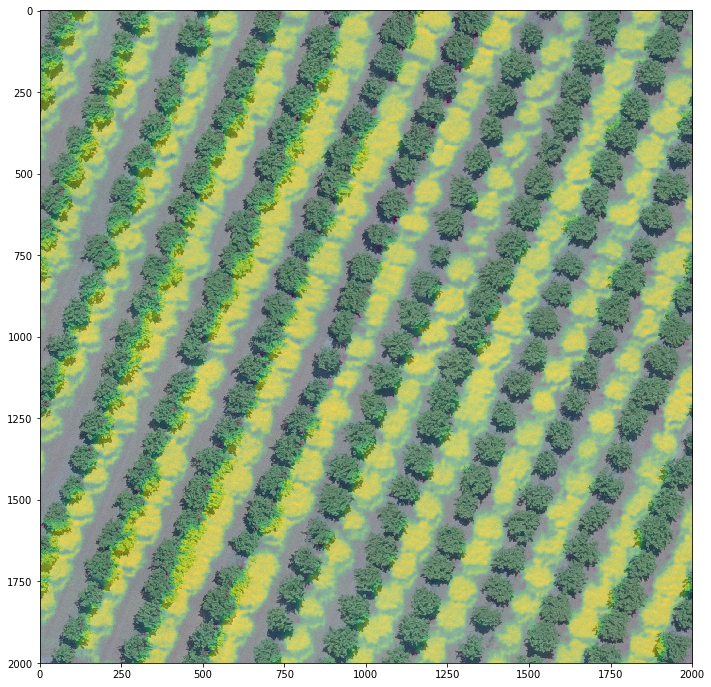

In [9]:
plt.figure(figsize=(12,12))
# Plot a smaller crop so that we can see more detail
plt.imshow(rgb_raster[4000:6000, 4000:6000, :])
# We have to resize the NDVI to the same shape as the RGB
plt.imshow(cv2.resize(ndvi_im, (rgb_raster.shape[1], rgb_raster.shape[0]))[4000:6000, 4000:6000], alpha=0.5)

To no surprise, it is misaligned!

Note, that if the above image is unclear, it is because some of the NDVI rasters have pixels with intensities far out of the [-1,1] range. This can be corrected by clipping these values at [-1,1].

To align these images we want to find points in the NDVI image that match with points in the RGB image. Once we have these points we can use the RANSAC algorithm to determine how to translate, rotate and scale the NDVI image to match the RGB image. We find matching points by first searching for interesting/unique points in the reference image, encode them using some appearance description and then find the corresponding points in the target image with the same encoding. I couldn't find point descriptors that are invariant to the different modalities so I decided to transform the RGB images to look as much as possible like the NDVI image and then go through the feature matching process.

I want the pixel intensities in both the NDVI and the transformed RGB images to be in the range [0,255]. I use the following function to normalize the NDVI in this way.

In [10]:
def normalize_ndvi(x):
    # Clip the pixel intensities at [-1,1]
    x[x < -1] = -1
    x[x > 1] = 1
    # Transform to range [0,1]
    x = (x + 1)/2
    # Transfrom to trange [0,255]
    x *= 255
    return x.astype('uint8')

Normalize the NDVI image and resize it to match the RGB raster such that there is a 1-1 correspondence between the pixels in the NDVI and the RGB images.

In [11]:
ndvi_norm = normalize_ndvi(ndvi_im)
ndvi_norm = cv2.resize(ndvi_norm, (rgb_raster.shape[1], rgb_raster.shape[0]))

Now to make the RGB look like the NDVI. There is no deterministic way get NDVI intensities from RGB values. I first tried learning an autoencoder using a CNN to map RGB pixels to NDVI but I had limited success (it produced a lot of artifacts in its outputs). Luckily I found something much simpler, the [Triangular Greenness Index](https://agribotix.com/blog/2017/04/30/comparing-rgb-based-vegetation-indices-with-ndvi-for-agricultural-drone-imagery/) (TGI). As mentioned in the link, TGI is not a drop-in replacement for NDVI, but I found it to be correlated enough with NDVI to work for this purpose.

In the following cell we get the TGI from the RGB image.

In [12]:
# Function to transform values to [0,1] range
def norm01(x):
    mn = np.min(x)
    mx = np.max(x)
    return (x-mn)/(mx-mn)

# Convert RGB values to TGI
def rgb2tgi(x):
    tgi = x[:,:,1]-0.39*x[:,:,0]-0.61*x[:,:,2] # TGI formula
    # Normalize to [0,1] to increase the contrast between intensities
    tgi = norm01(tgi)
    tgi *= 255 # Scale to [0,255] range
    return tgi.astype('uint8')

tgi = rgb2tgi(rgb_raster)

Unfortunately my feature matching approach did not work at very high resolutions (still need to figure out why) so therefore I resize both images to 500X500.

In [13]:
sz = 500

tgi = cv2.resize(tgi, (sz,sz))
ndvi_norm = cv2.resize(ndvi_norm, (sz,sz))

Now we can compare the TGI image with the normalized NDVI image.

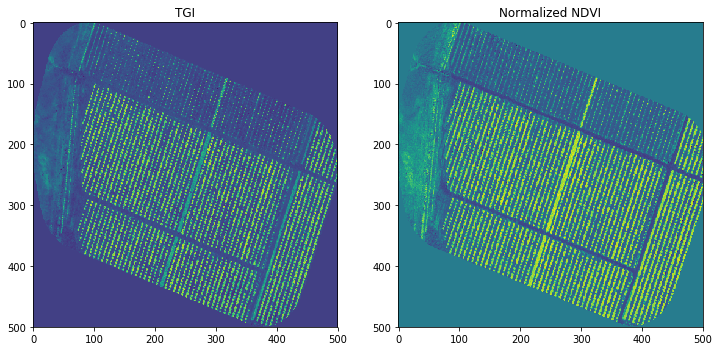

In [14]:
fig, axes = plt.subplots(1,2,figsize=(12,12))
axes[0].set_title('TGI')
axes[0].imshow(tgi)
axes[1].set_title('Normalized NDVI')
tmp = axes[1].imshow(ndvi_norm)

Besides the background, these two images actually look quite similar, although not identical. Let's see if our feature matching algorithm agrees.

I opted for using SIFT features to describe points in an image - it seemed to be more effective than ORB features in my experiments. The following cell finds interesting points in each image and describes them using SIFT features.

In [15]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints_ndvi, descriptors_ndvi= sift.detectAndCompute(ndvi_norm, None)
keypoints_tgi, descriptors_tgi = sift.detectAndCompute(tgi, None)

Now we have coordinates and descriptions for all 'interesting' points in both images. Next, we can use a brute force algorithm to match the keypoints in the NDVI with the points in the TGI, *i.e.* we literally measure the distance between every pair of points in terms of their descriptors and match each point in the NDVI image with its closet TGI point. We use the ratio test proposed by the [SIFT author](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) to throw away the bad matches.

In [16]:
# Brute force matcher with default params
bf = cv2.BFMatcher()

# The following line actually matches each ndvi point with its 2 closest TGI points
# We need the second closest point to do the ratio test.
matches = bf.knnMatch(descriptors_ndvi, descriptors_tgi, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# Plot the images along with their good matches
imMatches = cv2.drawMatchesKnn(ndvi_norm, keypoints_ndvi, tgi, keypoints_tgi, good, None, flags=2)

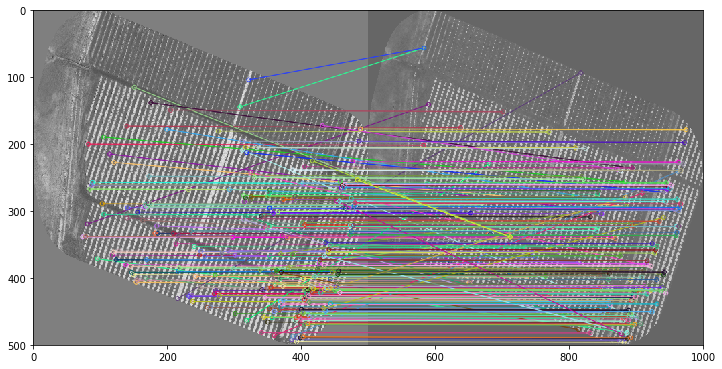

In [17]:
plt.figure(figsize = (12,12))
plt.imshow(imMatches)

As we can see, some of the matches are incorrect. Luckily the RANSAC algorithm can ignore outliers. So if if we have enough good matches, RANSAC will return the optimal translation, rotation and scale.

The following code extracts the keypoints of the good matches in the right format and then we make sure visually if they are correct.

In [18]:
# get the coordinates of the good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)

for i, match in enumerate(good):
    points1[i, :] = keypoints_ndvi[match[0].queryIdx].pt
    points2[i, :] = keypoints_tgi[match[0].trainIdx].pt

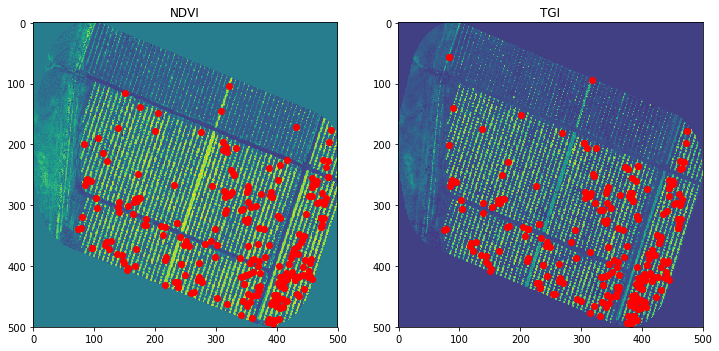

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].set_title('NDVI')
ax[0].imshow(ndvi_norm)
ax[0].scatter(points1[:,0], points1[:,1], c='red')
ax[1].set_title('TGI')
ax[1].imshow(tgi)
ax[1].scatter(points2[:,0], points2[:,1], c='red')

If we find the affine transformation between these two sets of points we will know how to warp the 500x500 NDVI image to align with the 500x500 TGI image. We can go down this path, but that would mean that we must then upscale the images to its original size and this will look bad since we already dropped a lot of information. So what we actually want to do is know how to transform the original NDVI raster to align with the original RGB raster. Since we already have the coordinates of matching points, we can transform then to fit the original rasters and then find the affine transformation in the original raster space.

This transformation of the keypoint is just a scaling to its original dimensions and a translation to correct fort the crop of the NDVI.

In [20]:
x_mult_ndvi = ndvi_im.shape[0]/ndvi_norm.shape[0]
y_mult_ndvi = ndvi_im.shape[1]/ndvi_norm.shape[1]

x_mult_tgi = rgb_raster.shape[0]/tgi.shape[0]
y_mult_tgi = rgb_raster.shape[1]/tgi.shape[1]

points1[:,0] = points1[:,0] * y_mult_ndvi + ndvi_pix_origin[1]
points1[:,1] = points1[:,1] * x_mult_ndvi + ndvi_pix_origin[0]

points2[:,0] = points2[:,0] * y_mult_tgi #+ ndvi_pix_origin[1]
points2[:,1] = points2[:,1] * x_mult_tgi #+ ndvi_pix_origin[0]

Let's see if the transformed points actually fit on the original rasters:

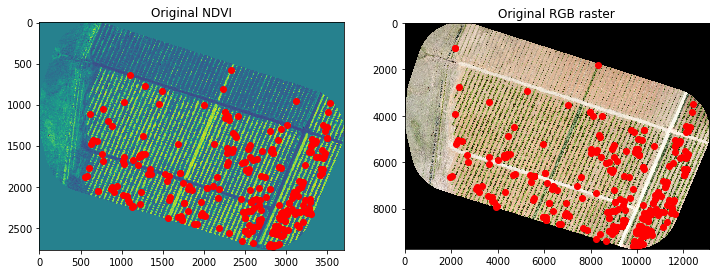

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].set_title('Original NDVI')
ax[0].imshow(ndvi_raster)
ax[0].scatter(points1[:,0], points1[:,1], c='red')
ax[1].set_title('Original RGB raster')
ax[1].imshow(rgb_raster)
ax[1].scatter(points2[:,0], points2[:,1], c='red')

It does! Now we can just find the affine transformation between the two sets of points using the RANSAC algorithm:

In [22]:
h = cv2.estimateRigidTransform(points1, points2, False)

`h` is a matrix containing the estimated parameters of the transform and thus we use it to warp the misaligned NDVI raster to obtain an aligned version thereof.

In [23]:
height, width = rgb_raster.shape[:2]
ndvi_aligned = cv2.warpAffine(ndvi_raster, h, (width, height))

The moment of truth - is `ndvi_aligned` actually aligned with `rgb_raster`? Let's check with the same overlay plot we did at the beginning of this notebook:

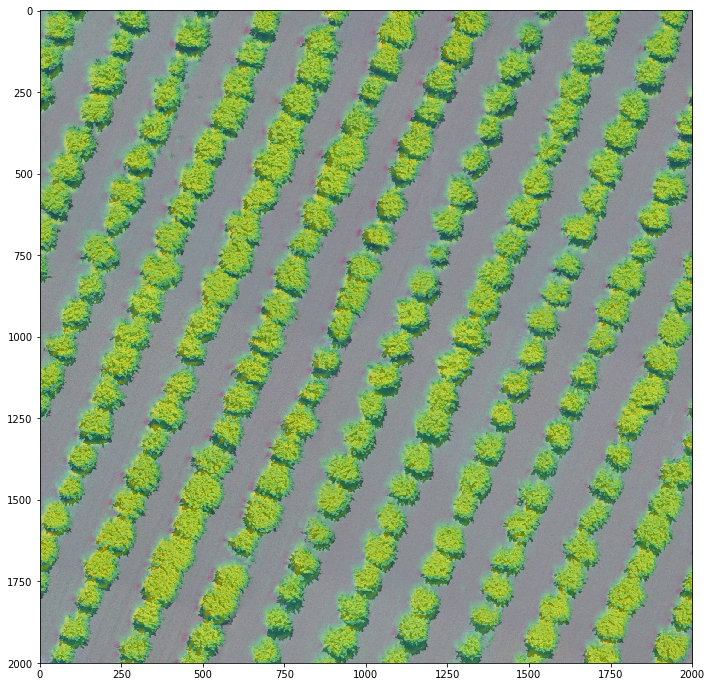

In [24]:
plt.figure(figsize=(12,12))
plt.imshow(ndvi_aligned[4000:6000, 4000:6000])
plt.imshow(rgb_raster[4000:6000, 4000:6000,:], alpha=0.5)

For this subset of the data it looks quite good.

For better inspection we can write it to a geotif file and open it with software like Qgis. This is done in the following cell.

In [25]:
# load the rgb tif file - we need some of its details to write a new tif file
gdal_ob = gdal.Open(f'datasets/{ds}/orthomosaic_visible.tif', gdal.GA_ReadOnly)

# get the size
rows = gdal_ob.RasterXSize 
cols = gdal_ob.RasterYSize

# write the aligned ndvi array to a geotif file with the same geo transform and projection as the rgb geotif
driver = gdal_ob.GetDriver()

outdata = driver.Create(f'datasets/{ds}/predicted_ndvi.tif', rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(gdal_ob.GetGeoTransform()) # sets same geotransform as input
outdata.SetProjection(gdal_ob.GetProjection()) # sets same projection as input
outdata.GetRasterBand(1).WriteArray(ndvi_aligned) # write raster 
outdata.FlushCache() # saves to disk
outdata = None

Task completed!

## Conclusion

I tested this code with all 6 datasets given to me and the results look quite good to my untrained eye. It's difficult to visually determine if a patch is misaligned or whether it's just noise in that part of the image. But I guess it's up to you to judge. Just change the `ds` value at the start of the notebook to try with the other datasets.

Obvious directions to further improve this approach would be to look at alternatives for transforming RGB images to NDVI look-alikes and other methods for feature matching. The TGI transformation might fail for other landscapes. An alternative might be to take a supervised learning approach to map the RGB to NDVI intensities. The SIFT features were just the first best feature for this use case and we can still try to tweak it parameters or use completely different ones like ORB or SURF features. We can even try activations from a CNN as descriptors. The fact that this process sometimes fails at very high resolutions makes me doubtful of its robustness and is definitely something that needs to be investigated.

In my mind the holy grail solution would be a system that reads in the RGB and misaligned NDVI rasters and outputs the correct GeoTransform parameters for the NDVI raster. I explored this path a bit with 2-stream CNNs but could not yet get the network to learn anything useful. But I'm still hopeful that with a month or two's research and a little bit more data, progress can be made on this front.

I really enjoyed working on this problem. First time doing some old school computer vision, so I learned quite a lot and was surprised to see how well it performs (I'm still a Deep Learning fanboy though). So thank you for this opportunity and I would love to hear your comments.